In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client

In [2]:
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/giuspugl/perlmutter-login-node-base/proxy/8787/status,
Dashboard: /user/giuspugl/perlmutter-login-node-base/proxy/8787/status,Workers: 16
Total threads: 256,Total memory: 503.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36495,Workers: 16
Dashboard: /user/giuspugl/perlmutter-login-node-base/proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 503.14 GiB
Comm: tcp://127.0.0.1:32993,Total threads: 16
Dashboard: /user/giuspugl/perlmutter-login-node-base/proxy/42035/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:38455,


0.03294117647058824

In [3]:
import numpy as np
import time 
import healpy  as hp 
import dask.array as da
import pylab as pl 
import sparse 
import scipy 
from scipy import sparse  as sp 
from scipy.special import legendre


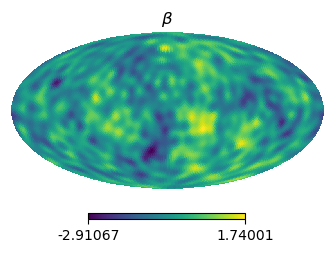

In [15]:
nside=32
lmax= nside*3 
cl= np.zeros(lmax-1)
ell = np.arange(1,lmax ) 
cl[:nside] = 1./ell[:nside] **2 
param = hp. synfast (cl, nside=nside ) 
hp.mollview(param,sub=121, title=r'$\beta$')

In [16]:
@dask.delayed 
def minmaxrescale(x, a=0, b=1):
    """
    Performs  a MinMax Rescaling on an array `x` to a generic range :math:`[a,b]`.
    """
    xresc = (b - a) * (x - x.min()) / (x.max() - x.min()) + a
    return xresc


def get_lmax(nside, stop_threshold):
    """
    Estimate  to which `lmax`    the heat kernel estimation  is stopped at a
    given `nside` resolution and a threshold `stop_threshold`.

    """
    pixscale = hp.nside2resol(nside=nside)
    sigmabeam = (pixscale) / pl.sqrt(8 * np.log(2))
    ell = np.arange(3 * nside - 1)
    arr = np.array(
        [(2 * l + 1) / 4.0 / np.pi * np.exp(-sigmabeam * l * (l + 1)) for l in ell]
    )
    lmax = np.argmin(np.fabs(arr - stop_threshold))

    return lmax, sigmabeam

In [17]:


@dask.delayed 
def heat_kernel(Theta, l, sigma):
    """
    Returns the functional Heat kernel given the cosine matrix `Theta` at a given `l`
    and `sigma`.
    """
    return (2 * l + 1) / 4.0 / np.pi * np.exp(-sigma * l * (l + 1)) * legendre(l)(Theta)

def build_adjacency_from_heat_kernel(nside ): 
    npix = hp.nside2npix(nside)
    p = np.arange(npix )
    V = da.from_array(np.array(hp.pix2vec(ipix=p, nside=hp.get_nside(p))).T, chunks="auto" )
    scalprod = minmaxrescale(V.dot(V.T), a=-1, b=1) 
    lmax, sigmabeam = get_lmax(nside, 1e-7)
    Gloc =[]

    for l in np.arange(lmax):
        Gloc .append( heat_kernel(
            scalprod, l, sigmabeam) ) 
    G = sum(Gloc)     
    return G

In [18]:
@dask.delayed 
def estimate_Laplacian_matrix(W, kind="unnormalized"):
    """
    Estimate the Laplacian matrix from the matrix of weights`W`.
    3 implementation of the Laplacian are available :
    - unnormalized
    - normalized
    - symmetric


    """

    ### Matrices that we are dealing with are sparse, it's more efficient to defined them as
    ### Compressed Sparse Row  (CSR ) matrices with scipy .
    diags = da.sum(W, axis=1) 
    D= da.diag(  diags)
    L = D -  W 
    if kind == "unnormalized":
        return L
    elif kind == "normalized":
        Dinv= da.diag( 1/ diags)
        
        Lnorm = Dinv.dot(L)
        return Lnorm
    elif kind == "symmetric":
        Dinv2= da.diag( 1/da.sqrt( diags)) 
        
        Lsym = Dinv2.dot(L.dot(Dinv2))
        return Lsym
    else:
        raise SyntaxError(
            ' "kind" can   be one among :  "unnormalized" ,  "normalized" , "symmetric"  '
        )
        

def from_ell_to_index(ell):
    """
    Returns the range of column values assuming  a matrix with columns ordered
    with the m multipole , m ranging from -ell to +ell
    """
    return ell ** 2, ell ** 2 + 2 * ell + 1

@dask.delayed      
def estimate_eigenv_distance(eigenvectors ): 
    D = scipy.spatial.distance_matrix(eigenvectors,eigenvectors,  p=2 ) 
    return D 
    
    
@dask.delayed      
def estimate_eigenv_distance(eigenvectors ): 
    D = scipy.spatial.distance_matrix(eigenvectors,eigenvectors,  p=2 ) 
    return D 

@dask.delayed 
def estimate_eigenv(L, N ): 
    l,W = sp.linalg.eigsh(
       sp.csr_matrix(L ) , k=N , return_eigenvectors=True, which="SM", tol=1e-12
    )
    return W 
        


In [19]:
def kolmogorov_smirnov_distance(x, y, ntests, nsamp):
    """
    Estimate for a pair `x` and `y` the Kolmogorov Smirnov Test, for `ntests` times,
    by resampling the measurements :math:`x\pm dx ` and :math:`y\pm dy ` with a
    normal distribution `nsamp` times.
    """
    mu1 = x[0]
    sigma1 = x[1]
    mu2 = y[0]
    sigma2 = y[1]
    D = []
    # We  repeat the KS test ntest times (it takes time) on two samples with same size n=m
    # np.random.seed(1234)

    for test in range(ntests):
        rvs1 = norm.rvs(size=nsamp, loc=mu1, scale=sigma1)
        rvs2 = norm.rvs(size=nsamp, loc=mu2, scale=sigma2)
        _, pval = ks_2samp(rvs1, rvs2)
        D.append(pval)
    med = np.median(D)
    return med

@dask.delayed 
def build_adjacency_from_KS_distance(
    nside,  X, sigmaX, ntests=50, nresample=100
):
    """
    Build the adjacency matrix  given the Kolmogorov Smirnov (KS) distance.
    /!\ This is one of the most computationally expensive routine in the whole package.

    - `nside`:{int}
    resolution parameter of the healpix map
    - `comm` : {MPI_COMM}
    the MPI communicator
    - `X`:{np.array}
    Healpix map  encoding the features to cluster
    - `sigmaX`:
    {np.array}
    Healpix map  encoding the uncertainties of the  features to cluster
    - `ntests`:{int}
    number of KS tests   for a given pairwise evaluation  (X1,sigmaX1) and (X2, sigmaX2)
    - `nresample`:{int}
    size of the bootstrap resampling of a measurement  (X1,sigmaX1)

    """
 
    npix = X.size
    offset_hpx = start_row
    for i in range(Qloc.shape[0]):
        X_i = (X[i + offset_hpx], sigmaX[i + offset_hpx])
        for j in range(npix):
            X_j = (X[j], sigmaX[j])
            q = kolmogorov_smirnov_distance(
                x=X_i, y=X_j, ntests=ntests, nsamp=nresample
            )
            Qloc[i, j] = q

    comm.Barrier()
    Q = comm.allgather(Qloc)
    Q = np.concatenate(Q).reshape((npix, npix))
    Q[np.diag_indices(npix)] = 0.0
    return minmaxrescale(Q, a=0, b=1)

### full  dask version  

In [20]:

lmax= nside -1
G = build_adjacency_from_heat_kernel(nside )
L = estimate_Laplacian_matrix(G ,kind='symmetric')


Nmax= np.int_(from_ell_to_index(lmax )[1])

E= estimate_eigenv(L , Nmax ) 
eig_dist = estimate_eigenv_distance(E ) 


In [21]:
s= time.perf_counter() 

D= eig_dist.compute() 
e= time.perf_counter() 
print(f"estimate eigenv distance,{e -s}" ) 

estimate eigenv distance,1943.4432692548726


### without dask 

In [12]:
s= time.perf_counter() 
lapl=sp.csr_matrix(L.compute() ) 
s1= time.perf_counter() 
print(f"compute laplacian,{s1-s}" )
Nmax= np.int_(from_ell_to_index(lmax )[1])
l,W = sp.linalg.eigsh(
       lapl, k=Nmax , return_eigenvectors=True, which="SM", tol=1e-12
    )
s2= time.perf_counter() 
print(f"estimate eigenv,{s2-s1}" )

E= da.from_array(W, chunks="auto"  ) 
s3= time.perf_counter() 
print(f"daskify eigenvect,{s3-s2}" )

s= time.perf_counter() 

eig_dist = estimate_eigenv_distance(E ) 
e= time.perf_counter() 
print(f"estimate eigenv distance,{e -s}" )


compute laplacian,6.848360290052369
estimate eigenv,6.359988973941654
daskify eigenvect,0.004672029055655003
